# **Final Project Task 1 - Census Data Preprocess**

Requirements

- Target variable specification:
    - The target variable for this project is hours-per-week. 
    - Ensure all preprocessing steps are designed to support regression analysis on this target variable.
- Encode data  **3p**
- Handle missing values if any **1p**
- Correct errors, inconsistencies, remove duplicates if any **1p**
- Outlier detection and treatment if any **1p**
- Normalization / Standardization if necesarry **1p**
- Feature engineering **3p**
- Train test split, save it.
- Others?


Deliverable:

- Notebook code with no errors.
- Preprocessed data as csv.

**0. Instalare de librarii si incarcare de date:**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [2]:
# Display settings
pd.set_option('display.max_columns', None)

# Load the dataset
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = [
    "age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
    "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
    "hours-per-week", "native-country", "income"
]

# Note: We use skipinitialspace=True to handle spaces after commas
df = pd.read_csv(data_url, header=None, names=columns, na_values="?", skipinitialspace=True)

print(f"Initial shape: {df.shape}")
df.head()

Initial shape: (32561, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


**1. Curatarea de date:**

- Am sters duplicatele la nivel de rand, pentru ca e foarte improbabil ca doi indivizi sa impartaseasca valori identice pe fiecare coloana. Daca le pastram, puteam sa avem problema de overfitting cand era vorba de training set, deci am fi avut niste cifre mai unflate pe degeaba.
- Pentru valorile lipsa am observat ca se foloseste "?". Am facut o prima conversie in NaN, ca pe urma sa ma pot folosi de functii din panda sa scap de null-uri. 

In [3]:
initial_rows = df.shape[0]
df = df.drop_duplicates()
print(f"Removed {initial_rows - df.shape[0]} duplicate rows.")

df['income'] = df['income'].map({'<=50K': 0, '>50K': 1})

categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"{col}: {df[col].unique()}")

Removed 24 duplicate rows.
workclass: ['State-gov' 'Self-emp-not-inc' 'Private' 'Federal-gov' 'Local-gov' nan
 'Self-emp-inc' 'Without-pay' 'Never-worked']
education: ['Bachelors' 'HS-grad' '11th' 'Masters' '9th' 'Some-college' 'Assoc-acdm'
 'Assoc-voc' '7th-8th' 'Doctorate' 'Prof-school' '5th-6th' '10th'
 '1st-4th' 'Preschool' '12th']
marital-status: ['Never-married' 'Married-civ-spouse' 'Divorced' 'Married-spouse-absent'
 'Separated' 'Married-AF-spouse' 'Widowed']
occupation: ['Adm-clerical' 'Exec-managerial' 'Handlers-cleaners' 'Prof-specialty'
 'Other-service' 'Sales' 'Craft-repair' 'Transport-moving'
 'Farming-fishing' 'Machine-op-inspct' 'Tech-support' nan
 'Protective-serv' 'Armed-Forces' 'Priv-house-serv']
relationship: ['Not-in-family' 'Husband' 'Wife' 'Own-child' 'Unmarried' 'Other-relative']
race: ['White' 'Black' 'Asian-Pac-Islander' 'Amer-Indian-Eskimo' 'Other']
sex: ['Male' 'Female']
native-country: ['United-States' 'Cuba' 'Jamaica' 'India' nan 'Mexico' 'South'
 'Puerto-R

**3. Missing Value Imputation**

- Ca logica am folosit mode imputation, pentru ca avem valori lipsa in coloanele categorice, cum ar fi workclass, ocupation si native-country.
- Nu am sters pur si simplu randurile de data asta pentru ca ar fi redus marimea de sample si puteam sa avem un bias in date daca valorile lipsa nu ar fi fost random. Ideea de baza e ca, de exemplu, cei care sunt neangajati poate au lasat necompletat la occupation, deci daca am scapa de ele am crea un bias impotriva predictiilor hours-per-week.
- Am folosit mode pana la urma si din ce am observat la nivel de date:
    - La native-country, valoarea "United States" e foarte dominanta, undeva la peste 90%, deci o asumptie ca lipsurile ar fi tot US ar fi statistic safe.
    - La workclass si occupation, valorile "Private" si "Prof-speciality/Craft-repair" sunt dominante. Daca folosim mode aici prezervam probabilitatea distributiei setului de date mai bine, in loc sa cream o categorie "Unknown".

In [4]:
print(df.isnull().sum())

for col in ['workclass', 'occupation', 'native-country']:
    df[col] = df[col].fillna(df[col].mode()[0])

print("Missing values after imputation:")
print(df.isnull().sum())

age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     582
income               0
dtype: int64
Missing values after imputation:
age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64


**4. Feature Engineering**

- Pentru a imbunatati performanta regresiei, am creat cateva valori cu o insemnatate mai puternica:
    - net-capital (Capital Gain - Capital Loss): Cele doua variabile "capital-gain" si "capital-loss" sunt majoritar 0 si nu prea se gasesc impreuna pe acelasi rand. Daca le combinam ca o diferenta dintre cele doua putem reduce dimensionalitatea, in timp ce pastram notiunea de capital net al individului. O valoare mare de net-capital poate corela cu capital prin investitii, deci ore mai putine de lucru, sau viceversa, rol foarte important care necesita mai multe ore de lucru.
    - native-region (US vs. Non-US): native-country are o cardinalitate mare cu mica varianta (pentru ca majoritaeta sunt US). Prin codare one-hot cuplam toate tarile in aproximativ 40 de coloane, care aduc dimensionalitate, dar de care putem scapa prin gruparea lor binara.
    - is-married (grupare maritala): Exista foarte multe subcategorii in "marital-status" care provoaca batai de cap, si am zis ca ar fi mai ok sa impartim binar in doua categorii in functie daca invidiul este ajutata (sau ajuta) o a doua persoana prin acest statut marital. Asadar se formeaza doua categorii: daca statutul implica un maritaj activ (adica doua persoane care se pot ajuta impreuna si pot avea grija unul de celalalt) si opusul.

In [5]:
# 1. Net Capital
df['net-capital'] = df['capital-gain'] - df['capital-loss']

# 2. US vs. Non-US
df['native-region'] = df['native-country'].apply(lambda x: 'United-States' if x == 'United-States' else 'Other')

# 3. is-married 
df['is-married'] = df['marital-status'].apply(lambda x: 1 if 'Married' in x else 0)

df = df.drop(columns=['education', 'native-country', 'capital-gain', 'capital-loss'])

**5. Outlier Detection and Treatment**
- Am mers pe intercuartile, si am tratat outleir-ii din valorile numerice precum fnlwgt, age, net-capital.
- Nu le-am eliminat pentru ca vrem sa invatam din extreme ceva, dar nu vrem ca ele sa domine in squared-error. Exista posibilitate logica de net-capital mare sau de age mare. Prin adaugade de cap putem inca observa aceste valori mari, fara a fi influentati de outlier-ii (cum ar fi bilionarii).
- Nu am pus cap pe variabila pe care vrem sa o explicam, pentru ca outlier-ii adevarat sunt adevaruri de baza pe care noi vrem sa le prezicem. Daca puneam cap, automat micsoram artificial varianta pe care vrem sa o modelam.

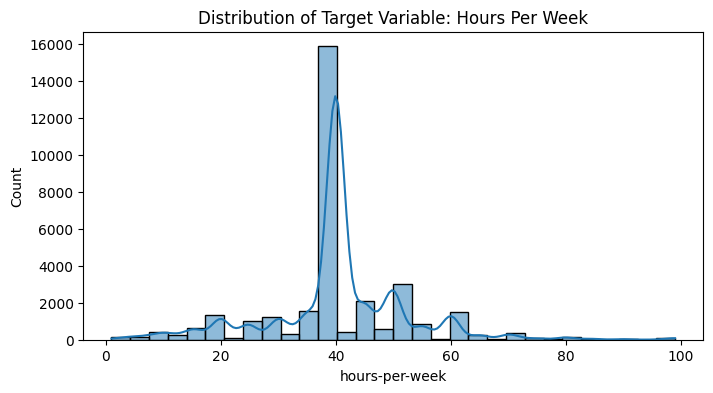

In [6]:
def cap_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return series.clip(lower=lower_bound, upper=upper_bound)

for col in ['age', 'fnlwgt', 'net-capital']:
    df[col] = cap_outliers(df[col])

plt.figure(figsize=(8, 4))
sns.histplot(df['hours-per-week'], bins=30, kde=True)
plt.title('Distribution of Target Variable: Hours Per Week')
plt.show()

**6. Standardizare**
- Aplicam codate one-hot pentru variabilele nominale si drop-first. Daca era sa mergem pentru label encoding, am fi asignat integers, ce ar implica o relatie ordinala care nu exista. Nu ne ajuta cu nimic.
- Prin drop first am prevenit multicoloniaritatea. 
- Am normalizat prin z-score pentru a normaliza putin modelul de regresie, pentru ca e foarte sensibil la scala pe care variabilele le au, cum ar fi varsta de la 17 la 90, sau fnlwgt care e in interval de milioane. Fara o scala, modelul ar avea bias pentru fnlwgt doar pentru ca valorile sunt mult mai mari.
- Am ales standardiazre in loc de scalare min-max pentru ca datele contin outlier-i chiar si dupa capping. Min-max ar fi compresat majoritatea datelor normale intr-un range foarte mic datorita outliers, insa prin standardizare avem o distributie mai normala.

In [7]:
X = df.drop(columns=['hours-per-week'])
y = df['hours-per-week']

numeric_features = ['age', 'fnlwgt', 'education-num', 'net-capital']
categorical_features = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-region']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

X_processed = preprocessor.fit_transform(X)

ohe = preprocessor.named_transformers_['cat']
cat_feature_names = ohe.get_feature_names_out(categorical_features)
all_feature_names = numeric_features + list(cat_feature_names) + ['income', 'is-married']

X_final = pd.DataFrame(X_processed, columns=all_feature_names)

print(f"Processed feature shape: {X_final.shape}")
X_final.head()

Processed feature shape: (32537, 43)


,age,fnlwgt,education-num,net-capital,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,occupation_Armed-Forces,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male,native-region_United-States,income,is-married
0,0.032472,-1.149209,1.134777,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
1,0.844002,-1.088284,1.134777,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
2,-0.041304,0.303007,-0.420679,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
3,1.065329,0.503550,-1.198407,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
4,-0.779058,1.593665,1.134777,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


**7. Train-Test:**

- Train-test de proportii 80/20 a fost folosit la random state cu 42 pentru reproductibilitate.
- Nu am stratificat, pentru ca acestea de obicei se folosesc pentru clasificari pentru a balansa clasele. Pentru regresia noastra, random sampling este in general suficient, daca nu distributia target este foarte skewed, motiv pentru care atunci stratificarea ar fi mai buna. Aici nu se pune aceasta problema.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

print(f"Training Data Shape: {X_train.shape}")
print(f"Test Data Shape: {X_test.shape}")

processed_data = X_final.copy()
processed_data['hours-per-week'] = y.values

processed_data.to_csv('adult_data_preprocessed.csv', index=False)
print("Data saved to 'adult_data_preprocessed.csv'")

Training Data Shape: (26029, 43)
Test Data Shape: (6508, 43)
Data saved to 'adult_data_preprocessed.csv'
